In [1]:
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shutil
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def plot_err(x_input, results, labels, xylabels, title=None, path=None, plottype=None):
    with PdfPages(f'{path}/{title.replace(" ", "_")}.pdf') as pdf:
        for i, (xaxis, result, label) in enumerate(zip(x_input, results, labels)):
            if plottype=='semilogx':
                plt.semilogx(xaxis, result, label=label, color=f'C{i}')
            elif plottype=='semilogy': 
                plt.semilogy(xaxis, result, label=label, color=f'C{i}')
            elif plottype=='loglog': 
                plt.loglog(xaxis, result, label=label, color=f'C{i}')
            else:
                if i==0:
                    plt.scatter(xaxis, result, label=label, s=100, color=f'C{i}', marker=r'$\clubsuit$')
                elif i>0:
                    index = np.argsort(xaxis).astype(int)
                    xaxis = [ xaxis[i] for i in index ]
                    result = [ result[i] for i in index ]
                    # print(f'index={index}')
                    plt.plot(xaxis, result, label=label, color=f'C{i}', marker='.')
                else:
                    plt.plot(xaxis, result, label=label, color=f'C{i}', marker='.')
        # if title:
        #     plt.title(title)
        plt.xlabel(xylabels[0])
        plt.ylabel(xylabels[1])
        plt.legend()
        plt.grid()
        if path:
            pdf.savefig()
        plt.show()

In [3]:
def extract_curve(file_path):
    file_target = open(file_path, 'r')
    perfs, fairs = np.empty([0]), np.empty([0])
    for i, line in enumerate(file_target):
        ls = line.strip('\n')
        if "- test acc" in ls:
            acc = re.findall(r"test acc:(.*?)[,$]", ls)
            acc = np.float_(acc)
            perf = acc
            perfs = np.concatenate((perfs, perf))

            # D_SP = np.float_(re.findall(r"DP test:(.*)", ls)[0])
            D_SP = re.findall(r"DP test:(.*)", ls)
            fair = np.float_(D_SP)
            fairs = np.concatenate((fairs, fair))
        elif "- test mae" in ls:
            acc = re.findall(r"test mae:(.*?)[,$]", ls)
            acc = np.float_(acc)
            perf = acc
            perfs = np.concatenate((perfs, perf))

            # D_SP = np.float_(re.findall(r"DP test:(.*)", ls)[0])
            D_SP = re.findall(r"DP test:(.*)", ls)
            fair = np.float_(D_SP)
            fairs = np.concatenate((fairs, fair))
        elif "Average of performance and fairness metric:" in ls:
            break
    return perfs, fairs

def extract_perf(file_path):
    file_target = open(file_path, 'r')
    for i, line in enumerate(file_target):
        ls = line.strip('\n')
        if "Test statistics" in ls:
            if "acc" in ls:
                acc = re.findall(r"acc:(.*?)[,$]", ls)[0]
                # print(f'acc={acc}')
                acc = np.float_(acc.split('+-'))
                perf = acc
            elif "mae" in ls:
                acc = re.findall(r"mae:(.*?)[,$]", ls)[0]
                acc = np.float_(acc.split('+-'))
                perf = acc
            elif "D_SP" in ls:
                D_SP = re.findall(r"D_SP:(.*)", ls)[0]
                D_SP = np.float_(D_SP.split('+-'))
                fair = D_SP
    return perf, fair

In [4]:
file_path = f'./log/clf/kernel/attn-map-hyper=0.0-4.log'
perf, fair = extract_perf(file_path)
perf 

array([0.6637, 0.0729])

In [5]:
perf, fair = extract_curve(file_path)
fair

array([], dtype=float64)

In [6]:
def results_extract(method, task, model, alpha_vec=None, running_times=5):
    perfs, fairs = np.empty([0,2]), np.empty([0, 2])

    methods = ["kernel", "kernel_bn", "adv", "adv_bn"]
    
    if method in methods:
        index = methods.index(method)
        alphas = alpha_vec[index]
        for alpha in alphas:
            file_path = f'./log/{task}/{method}/attn-{model}-hyper={alpha}-{running_times-1}.log'
            
            perf, fair = extract_perf(file_path)
            
            perfs = np.concatenate((perfs, np.expand_dims(perf, 0)))
            fairs = np.concatenate((fairs, np.expand_dims(fair, 0)))

    return perfs, fairs

In [7]:
def results_all(methods, task, model, alpha_vec=None, running_times=5):
    perfs, fairs = [], []
    for method in methods:
        perf, fair = results_extract(method, task, model, alpha_vec, running_times)
        perf, fair = list(perf[:,0]), list(fair[:,0])
        if method=="kernel":
            perfs.append(perf[0:1])
            fairs.append(fair[0:1])

        perfs.append(perf[1:])
        fairs.append(fair[1:])
    ### return len(methods) + 1
    return perfs, fairs

In [129]:
def plot_tradeoff(method_vec, task, model, alpha_vec, xylabels):
    perfs, fairs = results_all(method_vec, task, model, alpha_vec)

    xaxis = fairs
    results = perfs
    results[4] = list(np.array(results[4]) - 0.03)
    labels = ['vanilla', 'kernel', 'kernel_bn', 'adv', 'adv_bn']
    # xylabels = ['DP', 'MAE']
    title = f'{task}_{model}_tradeoff'
    path = 'results'

    plot_err(xaxis, results, labels, xylabels, title, path)

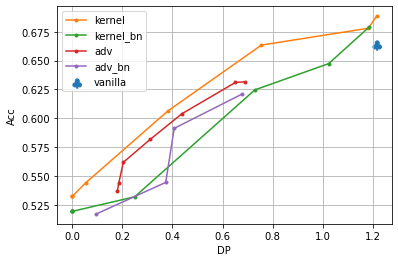

In [127]:
task = 'clf'  ## 'clf' 'reg'
model = 'map' ## 'map' 'prod
xylabels = ['DP', 'Acc']
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.5, 1.0, 3.0, 5.0, 7.0, 10.0, 20.0, 50.0],
            [0.0, 0.3, 1.0, 3.0, 5.0, 7.0, 10.0, 20.0, 50.0],
            [0.0, 10.0, 100.0, 800.0, 1000.0, 1500.0, 2000.0, 3000.0],
            [0.0, 10.0, 500.0, 2000.0, 5000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, task, model, alpha_vec, xylabels)

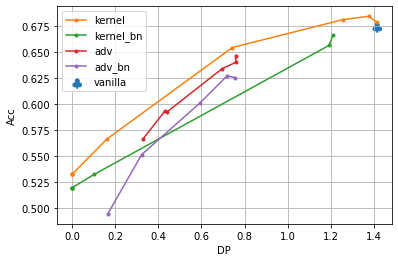

In [131]:
task = 'clf'  ## 'clf' 'reg'
model = 'prod' ## 'map' 'prod
xylabels = ['DP', 'Acc']
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.3, 0.5, 0.7, 3.0, 5.0, 7.0, 10.0, 20.0, 50.0],
            [0.0, 0.7, 1.0, 3.0, 5.0, 7.0, 10.0, 20.0],
            [0.0, 10.0, 50.0, 100.0, 800.0, 1000.0, 3000.0],
            [0.0, 10.0, 100.0, 500.0, 2000.0, 5000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, task, model, alpha_vec, xylabels)

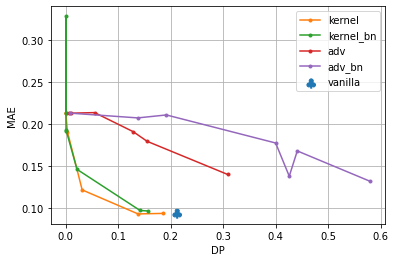

In [105]:
task = 'reg'  ## 'clf' 'reg'
model = 'map' ## 'map' 'prod
xylabels = ['DP', 'MAE']
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.1, 0.3, 1.0, 5.0, 10.0, 20.0, 50.0],
            [0.0, 0.1, 0.3, 1.0, 5.0, 10.0, 20.0, 50.0],
            [0.0, 10.0, 50.0, 100.0, 500.0, 800.0, 1500.0],
            [0.0, 10.0, 50.0, 100.0, 300.0, 500.0, 800.0, 2000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, task, model, alpha_vec, xylabels)

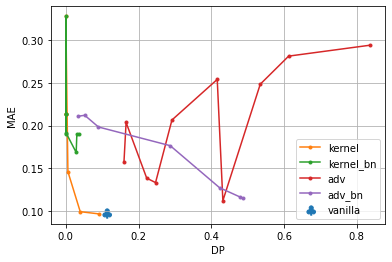

In [106]:
task = 'reg'  ## 'clf' 'reg'
model = 'prod' ## 'map' 'prod
xylabels = ['DP', 'MAE']
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.3, 0.7, 1.0, 5.0, 10.0, 20.0, 50.0],
            [0.0, 0.3, 0.5, 0.7, 1.0, 5.0, 10.0, 20.0, 50.0],
            [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 1500.0, 2000.0, 3000.0, 5000.0],
            [0.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0, 5000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, task, model, alpha_vec, xylabels)